# sparkify 会员用户流失预测
## 项目概览
　　sparkify是一个类似于网易云音乐、QQ音乐等提供数字音乐服务的平台。用户类型有带广告的免费用户、会员用户。 会员用户每月支付固定费用免费听歌。任何时候，用户可以自己升级为会员用户或者降级为免费用户。用户的每次操作，例如播放歌曲、点赞、登录、登出、升级、降级等都会产生数据，这些数据包含了能让用户满意并帮助sparkify业务蓬勃发展的关键信息。<br>
　　数据集来源于Udacity，完整的数据集大小为12GB。本项目基于完整数据集的一个子集，大小为231MB，预测哪些用户从会员降级为免费，或者直接取消服务了。如果在用户离开之前，可以精确识别到这些用户，sparkify可以通过给用户打折或者其他激励方式留住用户，这样就可以挽救数百位的营业额。[数据子集链接](https://video.udacity-data.com/topher/2018/December/5c1d6681_medium-sparkify-event-data/medium-sparkify-event-data.json) <br>
　　用户路径：
  + Register -> Submit Registration ->成为free用户，可以听歌、点赞、加好友等，带广告
  + free用户 -> Upgrade -> Submit Upgrade -> 成为paid用户，享受尊贵服务，无广告
  + paid用户 -> Downgrade -> Submit Downgrade -> 成为free用户
  + free, paid用户 -> Cancel -> Cancellation Confirmation -> 注销账户

## 解决方案
　　项目目标是要在用户离开之前，精确识别这些用户，通过打折或者其他激励措施留着用户，挽救营业额。通过历史数据，预测用户继续付费使用sparkify，还是流失，这是二元分类问题。具体解决思路如下：
+ **paid用户才会为sparkify带来营业额，所以首先需要过滤掉免费用户**
+ 根据用户路径，定义执行Submit Downgrade或者Cancellation Confirmation操作的用户为流失用户
+ 数据清理，处理数据集中数据缺失、异常值和数据格式问题
+ 数据集探索，对比会员用户与流失用户的行为，找出用户流失的潜在规律
+ 建模，使用机器学习中的分类模型，如SVM、决策树等，训练数据
+ 预测，使用训练好的模型，预测用户

## 评价指标
目标是找到流失用户，通过打折或者其他激励留住这些用户，另外把会员用户误识别为流失用户是有害的，因为打折或者激励会造成不必要的损失。使用F1 score作为评价指标，同时考虑精确率和召回率

$$ F1 = 2* \frac{precision \cdot recall}{precision + recall} $$

In [152]:
# 导入所需库
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, isnull, col, round, when, first
from pyspark.sql.functions import hour, minute, second, year, month, dayofmonth, to_timestamp, to_date, datediff, date_sub
from pyspark.sql.types import StringType, IntegerType, LongType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, LinearSVC
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, Normalizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import re
import time

## 加载数据

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
data = spark.read.json('medium-sparkify-event-data.json')

## 数据集清理

In [216]:
# 查看数据集字段信息
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# 查看数据集大小
data.count()

543705

In [5]:
# 概览
data.describe().collect()

[Row(summary='count', artist='432877', auth='543705', firstName='528005', gender='528005', itemInSession='543705', lastName='528005', length='432877', level='543705', location='528005', method='543705', page='543705', registration='528005', sessionId='543705', song='432877', status='543705', ts='543705', userAgent='528005', userId='543705'),
 Row(summary='mean', artist='527.5289537712895', auth=None, firstName=None, gender=None, itemInSession='107.30629109535502', lastName=None, length='248.66459278007807', level=None, location=None, method=None, page=None, registration='1.5355234148628062E12', sessionId='2040.8143533717732', song='Infinity', status='210.01829116892432', ts='1.540964541209808E12', userAgent=None, userId='60268.42669103512'),
 Row(summary='stddev', artist='966.1072451772758', auth=None, firstName=None, gender=None, itemInSession='116.72350849187941', lastName=None, length='98.41266955052018', level=None, location=None, method=None, page=None, registration='3.07872549299

In [6]:
# 统计userId为空的行
data.filter(data.userId == '').count()

15700

**userId有15700行空值，同时与userId相关的firstName, lastName, gender, registration, userAgent也为空值。因为需要对特定的用户做预测，所以需要处理userId为空的行**

In [7]:
# 统计artist, song, length同时为空的行数
data.filter(isnull('artist') & isnull('song') & isnull('length')).count()

110828

In [8]:
data.filter(isnull('artist')).show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In| Maverick|     M|          185|Santiago|  null| paid|Orlando-Kissimmee...|   PUT|Logout|1535953455000|      178|null|   307|1538352119000|"Mozilla/5.0 (Mac...|   179|
|  null|Logged Out|     null|  null|          186|    null|  null| paid|                null|   GET|  Home|         null|      178|null|   200|1538352148000|                null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| pai

用户访问Login, Logout, Home等页面时，没有听歌，所以歌曲相关信息artist, song, length为空是合理的，无需处理

In [9]:
# 查看用户使用终端
data.groupBy('userAgent').count().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', count=2050),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', count=3576),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', count=1897),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', count=46082),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"', count=2416),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', count=2034),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', count=9735),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Fi

用户使用终端信息包括hardware platform, app等信息，字符串很长，不便于分析，重点关注hardware platform， 例如客户用的是Windows, iPhone或者Macintosh等

### 数据集待清理问题
+ userId, 15700行空值
+ registration, 用户注册时间，用从epoch开始的秒数表示，long类型，不是timestamp
+ ts, 事件发生时间，用从epoch开始的秒数，long类型，不是timestamp 
+ userAgent, 字符串太长

### 清理

In [3]:
# 删除userId为空的行
data_clean = data.filter(data.userId != '')

# 将registration转为timestamp类型
data_clean = data_clean.withColumn('registration_time',to_timestamp(data_clean.registration / 1000))
data_clean = data_clean.drop('registration').withColumnRenamed('registration_time','registration')

# 将ts转为timestamp类型
data_clean = data_clean.withColumn('ts_time',to_timestamp(data_clean.ts / 1000))
data_clean = data_clean.drop('ts').withColumnRenamed('ts_time','ts')

In [4]:
# userAgent 截取终端信息
get_agent = udf(lambda x: re.search('(?<=\()\w*', x).group())
data_clean = data_clean.withColumn('platform',get_agent(data_clean.userAgent))
data_clean = data_clean.drop('userAgent').withColumnRenamed('platform','userAgent')

In [5]:
# 查看userAgent信息
data_clean.groupBy('userAgent').count().collect()

[Row(userAgent='iPad', count=16004),
 Row(userAgent='X11', count=25028),
 Row(userAgent='iPhone', count=14481),
 Row(userAgent='Macintosh', count=202059),
 Row(userAgent='compatible', count=21777),
 Row(userAgent='Windows', count=248656)]

## 探索性数据分析
### 用户数量统计

In [6]:
# 总用户数量
print('Total User: {}'.format(data_clean.select('userId').distinct().count()))

# 会员用户数量, 包括现有会员用户和流失会员
print('Paid User: {}'.format(data_clean.select('userId').where(data_clean.level == 'paid').distinct().count()))

# 流失会员数量
lost = data_clean.select('userId').where(data_clean.level == 'paid') \
                            .where((data_clean.page== 'Submit Downgrade') | (data_clean.page == 'Cancellation Confirmation')) \
                            .distinct().count()
print('Lost User: {}'.format(lost))

Total User: 448
Paid User: 321
Lost User: 151


研究对象用户448位，其只会员用户321位，免费用户127位。流失会员151位，占会员用户的47%，会员流失严重。  


**本项目关注的会员用户的行为，因此过滤掉免费用户，并添加一列churn用于标记是否为流失会员，1为流失，0为保留**

In [7]:
# 筛选会员用户的userId
userId_paid = data_clean.select('userId').where(data_clean.level == 'paid').distinct().rdd.flatMap(lambda x: x).collect()

# 过滤掉非会员用户数据
data_clean = data_clean.filter(data_clean.userId.isin(userId_paid))

# 流失用户userId
userIdLost = data_clean.select('userId').where((data_clean.page == 'Submit Downgrade') | (data_clean.page == 'Cancellation Confirmation')) \
                                   .distinct().rdd.flatMap(lambda x: x).collect()
get_tag = udf(lambda x: 1 if x in userIdLost else 0, IntegerType())

# 添加一列churn，1 表示流失会员，0表示保留会员
data_clean = data_clean.withColumn('churn', get_tag(data_clean.userId))

# 检查用户数量
data_clean.select('userId').distinct().count()

321

### 会员用户流失行为探索
+ **会员用户与流失用户的性别分布对比**

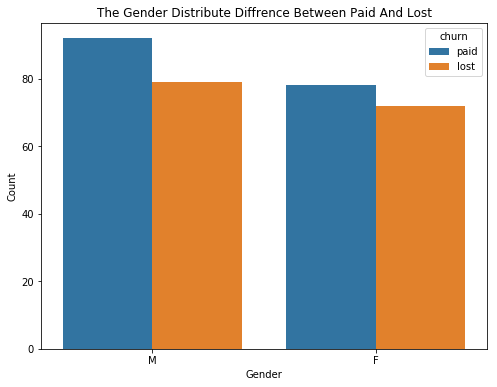

In [15]:
# 会员用户与流失用户的性别分布对比
data_temp = data_clean.select('userId','gender','churn').drop_duplicates(subset=['userId'])

plt.figure(figsize=(8,6))
sns.countplot(data = data_temp.toPandas(), x = 'gender', hue='churn',hue_order=[0,1])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(['paid','lost'],title='churn')
plt.title('The Gender Distribute Diffrence Between Paid And Lost');

会员用户与流失用户均男性偏多，但性别比例上两者并没有明显差异

 + **会员用户与流失用户使用sparkify时间段分布差异**

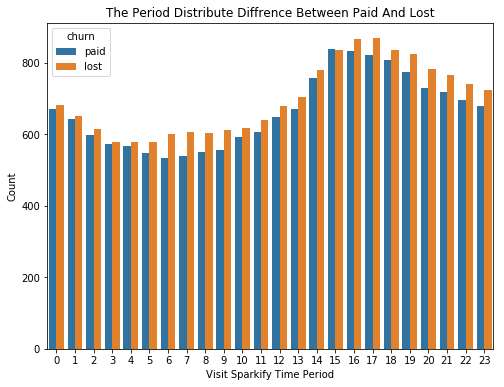

In [16]:
# 会员用户与流失用户使用sparkify时间段差异
data_temp = data_clean.select('userId','sessionId','ts','churn')
data_temp = data_temp.withColumn('period', hour(data_temp.ts))
# 过滤同一用户、同一时间段操作多次的行为
data_temp = data_temp.drop_duplicates(subset=['userId','sessionId','period'])

plt.figure(figsize=(8,6))
sns.countplot(data = data_temp.toPandas(), x = 'period', hue='churn', hue_order=[0,1])
plt.xlabel('Visit Sparkify Time Period')
plt.ylabel('Count')
plt.legend(['paid','lost'], title='churn')
plt.title('The Period Distribute Diffrence Between Paid And Lost');

会员用户与流失用户访问sparkify时间段上，两者均在3~10点是低谷，15~20点是高峰，在各个时间段，流失用户的活跃度略高

+ **会员用户与流失用户注册时间长短差异**

In [17]:
# 筛选用户的注册时间和最后的使用时间
data_temp = data_clean.select('userId','registration','ts', 'churn') \
              .groupBy('userId') \
              .agg({"ts": "max","registration": "max", "churn": "max"}) \
              .withColumnRenamed('max(registration)','registration') \
              .withColumnRenamed('max(ts)','ts') \
              .withColumnRenamed('max(churn)','churn')
# 添加duration列，表示从注册开始到最后时间为止的天数
data_temp = data_temp.withColumn('duration', datediff(data_temp.ts, data_temp.registration))

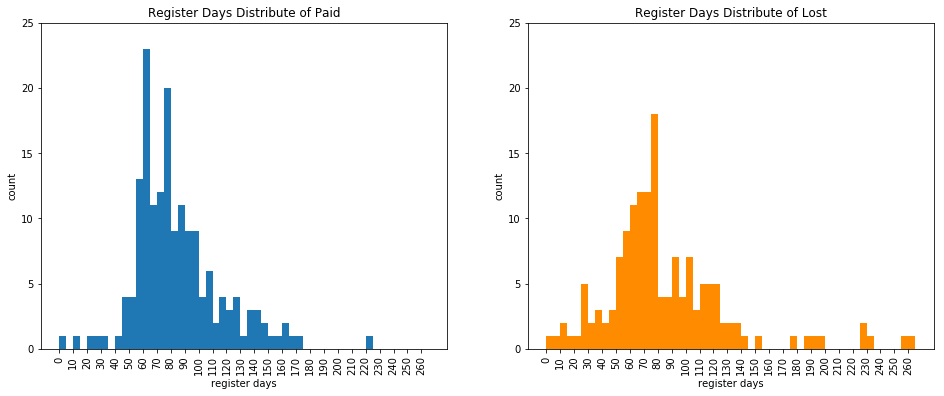

In [18]:
plt.figure(1, figsize=(16,6))
max_value = list(data_temp.groupBy().max('duration').collect()[0])[0]
bins = np.arange(0,max_value+5, 5)

data_temp_paid = data_temp.filter(data_temp.churn == 0)
plt.subplot(1,2,1)
plt.hist(data = data_temp_paid.toPandas(), x = 'duration', bins=bins)
xticks = np.arange(0, max_value, 10)
plt.xticks(xticks, xticks)
plt.xticks(rotation=90)
yticks = np.arange(0,25+5, 5)
plt.yticks(yticks, yticks)
plt.xlabel('register days')
plt.ylabel('count')
plt.title('Register Days Distribute of Paid')

data_temp_lost = data_temp.filter(data_temp.churn == 1)
plt.subplot(1,2,2)
plt.hist(data = data_temp_lost.toPandas(), x = 'duration', bins=bins, color='darkorange')
xticks = np.arange(0, max_value, 10)
plt.xticks(xticks, xticks)
plt.xticks(rotation=90)
yticks = np.arange(0,25+5, 5)
plt.yticks(yticks, yticks)
plt.xlabel('register days')
plt.ylabel('count')
plt.title('Register Days Distribute of Lost');

无论是现有会员用户还是流失用户，注册使用天数大部分都集中在110天以内，长期会员用户比例很低，注册天数是一个重要的指标

+ **会员用户与流失用户活跃度差异**  
用户的行为和时间有强关联性，例如用户刚刚注册的时候，新鲜感强，无论是使用时间还是使用次数都会多些；随着时间的推移，使用时间可能会随之减少。下面观察下用户行为与时间的关系:
    + 用户从注册以来活跃的天数，为对比不同注册时间的用户，使用活跃天数占比来表示
    + 用户最近两周活跃天数
    + 用户最近两周听歌数量

In [19]:
# 准备数据
data_temp = data_clean.select('userId','registration','page','ts','churn','sessionId')

# 筛选用户的注册时间和最后的使用时间
last_day = data_clean.select('userId','ts') \
              .groupBy('userId') \
              .agg({"ts": "max"}) \
              .withColumn('last_day', to_date('max(ts)')) \
              .withColumnRenamed('userId', 'id') \
              .drop('max(ts)')

data_temp = data_temp.join(last_day, data_temp.userId == last_day.id, 'left').drop('id')

# 过滤注册时间小于2周的用户
data_temp = data_temp.filter(datediff(data_temp.last_day, data_temp.registration) >= 14)

# 添加lastTwoWeeks列表示最近两周的日期
data_temp = data_temp.withColumn('lastTwoWeeks', date_sub(data_temp.last_day, 14))

active_day = data_temp.select('userId',to_date('ts').alias('activeDay')) \
                        .drop_duplicates(subset=['userId','activeDay']) \
                        .groupBy('userId') \
                        .agg({'activeDay' : 'count'}) \
                        .withColumnRenamed('count(activeDay)','activeDays') \
                        .withColumnRenamed('userId','id')

data_temp = data_temp.join(active_day, data_temp.userId == active_day.id, 'left').drop('id')

data_temp = data_temp.withColumn('activeDayProption', round(data_temp.activeDays / datediff(data_temp.last_day, data_temp.registration),2)*100)

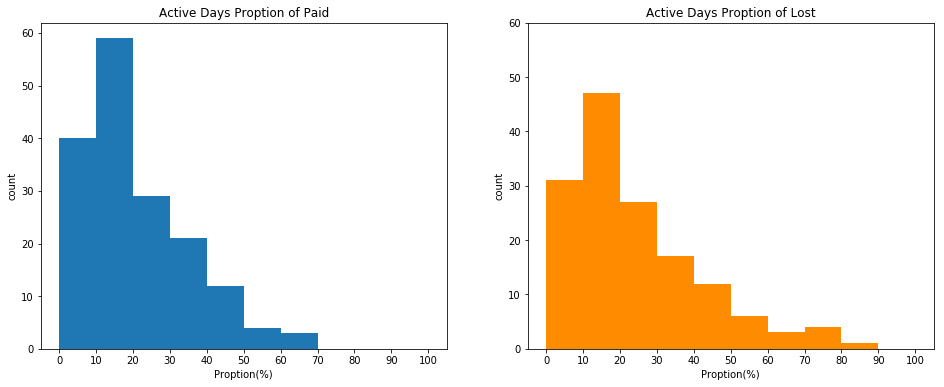

In [20]:
# 用户活跃天数比例
plt.figure(1, figsize=(16,6))
bins = np.arange(0, 100+1, 10)

plt.subplot(1,2,1)
data_temp_paid = data_temp.filter(data_temp.churn == 0).drop_duplicates(subset=['userId'])
plt.hist(data = data_temp_paid.toPandas(), x = 'activeDayProption', bins=bins)
plt.xticks(bins, bins)
plt.xlabel('Proption(%)')
yticks = np.arange(0,60+1,10)
plt.yticks(yticks, yticks)
plt.ylabel('count')
plt.title('Active Days Proption of Paid')

plt.subplot(1,2,2)
data_temp_lost = data_temp.filter(data_temp.churn == 1).drop_duplicates(subset=['userId'])
plt.hist(data = data_temp_lost.toPandas(), x = 'activeDayProption', bins=bins, color='darkorange')
plt.xticks(bins, bins)
yticks = np.arange(0,60+1,10)
plt.yticks(yticks, yticks)
plt.xlabel('Proption(%)')
plt.ylabel('count')
plt.title('Active Days Proption of Lost');

流失用户活跃天数比例超过40%的数量高于会员用户

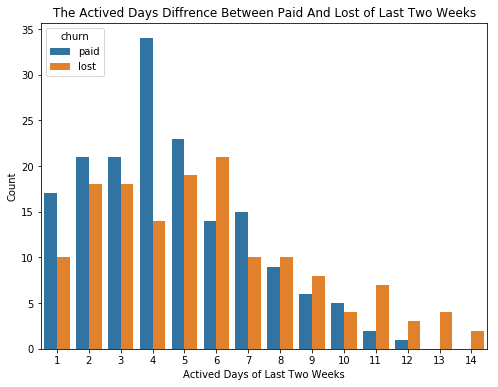

In [21]:
# 用户最近两周活跃天数
data_last2weeks = data_temp.filter(to_date(data_temp.ts) > data_temp.lastTwoWeeks)
data_last2weeks = data_last2weeks.select('userId',to_date('ts').alias('activeDay'),'churn') \
                        .drop_duplicates(subset=['userId','activeDay']) \
                        .groupBy('userId') \
                        .agg({'activeDay' : 'count', 'churn':'max'}) \
                        .withColumnRenamed('count(activeDay)','activeDays') \
                        .withColumnRenamed('max(churn)','churn')


plt.figure(figsize=(8,6))
sns.countplot(data = data_last2weeks.toPandas(), x = 'activeDays', hue='churn', hue_order=[0,1])
plt.xlabel('Actived Days of Last Two Weeks')
plt.ylabel('Count')
plt.legend(['paid','lost'], title='churn')
plt.title('The Actived Days Diffrence Between Paid And Lost of Last Two Weeks');

最近两周的活跃天数大于7天的用户中，流失用户数量也是高于会员用户

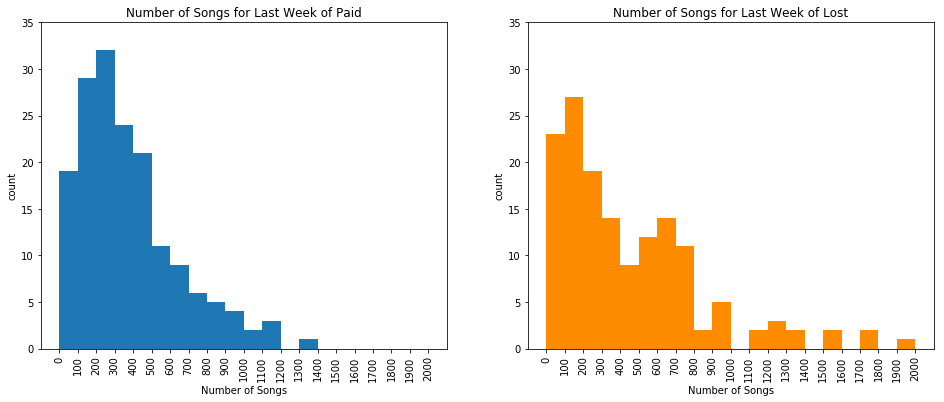

In [22]:
# 用户最近两周听歌数量
plt.figure(1, figsize=(16,6))

data_last2weeks = data_temp.filter(to_date(data_temp.ts) > data_temp.lastTwoWeeks)
data_last2weeks = data_last2weeks.select('userId', 'page','churn').where(data_last2weeks.page == 'NextSong') \
              .groupBy('userId') \
              .agg({"page": "count", "churn": "max"}) \
              .withColumnRenamed('count(page)', 'counts') \
              .withColumnRenamed('max(churn)','churn')

max_value = list(data_last2weeks.groupBy().max('counts').collect()[0])[0]
bins = np.arange(0,max_value+100, 100)

plt.subplot(1,2,1)
data_last2weeks_paid = data_last2weeks.where(data_last2weeks.churn == 0)
plt.hist(data=data_last2weeks_paid.toPandas(), x='counts',bins=bins)
plt.xticks(bins, bins)
plt.xticks(rotation=90)
yticks = np.arange(0,35+1,5)
plt.yticks(yticks, yticks)
plt.xlabel('Number of Songs')
plt.ylabel('count')
plt.title('Number of Songs for Last Week of Paid')

plt.subplot(1,2,2)
data_last2weeks_lost = data_last2weeks.where(data_last2weeks.churn == 1)
plt.hist(data=data_last2weeks_lost.toPandas(), x='counts', bins=bins, color='darkorange')
plt.xticks(bins, bins)
plt.xticks(rotation=90)
yticks = np.arange(0,35+1,5)
plt.yticks(yticks, yticks)
plt.xlabel('Number of Songs')
plt.ylabel('count')
plt.title('Number of Songs for Last Week of Lost');

从最近两周的听歌数量来看，流失用户更喜欢听歌，尤其听歌数量高于700首的流失用户数量高于会员用户

+ **会员用户与流失用户访问页面差异**

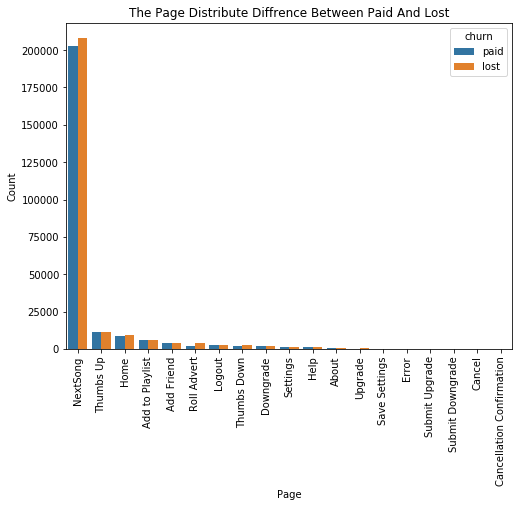

In [23]:
data_temp = data_clean.select('userId','page','churn')

order = data_temp.toPandas().page.value_counts().index

plt.figure(figsize=(8,6))
sns.countplot(data = data_temp.toPandas(), x = 'page', order=order, hue='churn',hue_order=[0,1])
plt.xlabel('Page')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['paid','lost'],title='churn')
plt.title('The Page Distribute Diffrence Between Paid And Lost')
plt.legend(['paid','lost'],title='churn',loc='upper right');

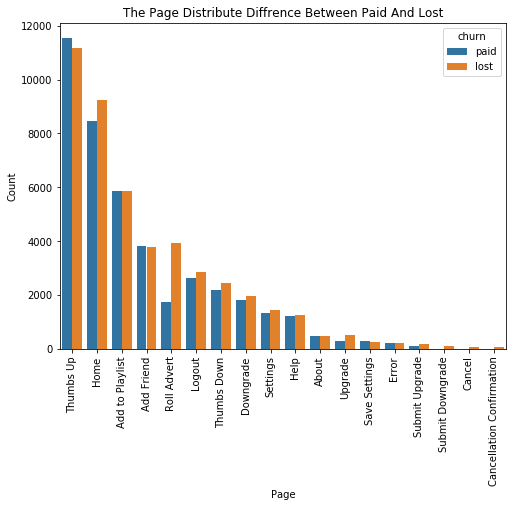

In [24]:
# NextSong的数值远高于其他Page, 为观察其他Page，先过滤掉NextSong
data_temp = data_clean.select('userId','page','churn').where(data_clean.page != 'NextSong')

order = data_temp.toPandas().page.value_counts().index

plt.figure(figsize=(8,6))
sns.countplot(data = data_temp.toPandas(), x = 'page', order=order, hue='churn',hue_order=[0,1])
plt.xlabel('Page')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['paid','lost'],title='churn')
plt.title('The Page Distribute Diffrence Between Paid And Lost')
plt.legend(['paid','lost'],title='churn',loc='upper right');

会员用户和流失用户访问NextSong page是最多的，远远高于其他page; 值得注意的是，流失用户Roll Advert比会员用户高出一倍，难道是Roll Advert影响了体验？Thumbs Down和Downgrade 流失用户也比会员用户高，这两个页面值得关注，Thumbs Down表示用户体验不好；用户访问Downgrade表示有取消服务的倾向，但没有真的取消服务，只有Submit Downgrade才真正取消。

+ **会员用户与流失用户使用的终端差异**

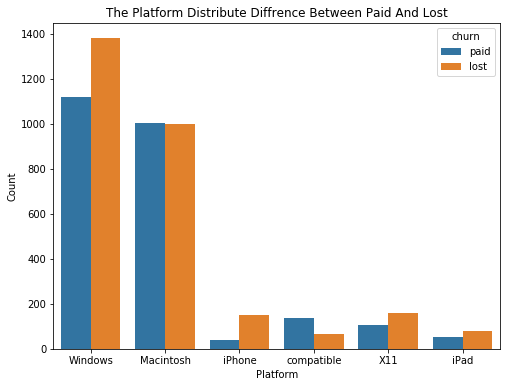

In [25]:
# 会员用户与流失用户使用终端差异
data_temp = data_clean.select('userId','userAgent','sessionId','churn')
# 过滤同一用户、同一时间段操作多次的行为
data_temp = data_temp.drop_duplicates(subset=['userId','sessionId'])

plt.figure(figsize=(8,6))
sns.countplot(data = data_temp.toPandas(), x = 'userAgent', hue='churn',hue_order=[0,1])
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(['paid','lost'], title='churn')
plt.title('The Platform Distribute Diffrence Between Paid And Lost');

sparkify用户中，使用Windows和Macintosh明显比其他终端多；流失用户使用iPhone的比例要明显高于会员用户，有可能是iPhone客户端的体验不好。

## 特征工程
综合数据探索结果，以下特征比较重要:
+ gender
+ 注册天数
+ 注册以来，活跃天数占比
+ 最近两周活跃天数占比，注册不足两周的，以注册以来的活跃天数占比替代
+ 最近两周听歌数量
+ 访问Roll Advert页面次数
+ 访问Thumbs Dowm页面次数
+ 访问Downgrade页面次数
+ platform

In [8]:
# 创建FeatureEngine, 用于从data_clean中提取特征， 也可用于从后续的新数据提取特征，用于预测
class FeatureEngine:
    '''
    从清理后的数据中提取关键特征，并对数据进行缩放；
    保存数据缩放模型，预测新数据时，先使用此模型缩放，再预测
    '''
    def __init__(self):
        pass
    
    def getFeature(self):
        # 提取特征
        # 添加一列gender_num，将gender中F, M 转为数字0,1
        get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
        self.data = self.data.withColumn('gender_num',get_gender(self.data.gender))
        
        # 添加一列lastDay, 表示最后使用的时间
        temp = self.data.select('userId','ts') \
                      .groupBy('userId') \
                      .agg({"ts": "max"}) \
                      .withColumnRenamed('max(ts)','lastDay')
        self.data = self.data.join(temp, 'userId', 'left')

        # 添加一列registDays表示从注册开始的天数
        self.data = self.data.withColumn('registDays', datediff(self.data.lastDay, self.data.registration))
        
        # 添加一列activeDays表示从注册以来的活跃天数
        temp = self.data.select('userId',to_date('ts').alias('activeDays')) \
                            .drop_duplicates(subset=['userId','activeDays']) \
                            .groupBy('userId') \
                            .agg({"activeDays": "count"}) \
                            .withColumnRenamed('count(activeDays)', 'activeDays')

        self.data = self.data.join(temp, 'userId', 'left')
        
        # 获取注册以来，活跃天数占比
        self.data = self.data.withColumn('activeProption',round(self.data.activeDays / self.data.registDays, 2))

        # 添加一列last2week,表示从lastDay倒推2周的日期，如果注册不足两周，以registration日期代替
        self.data = self.data.withColumn('lastDaySub2Week',date_sub(self.data.lastDay, 14))
        self.data = self.data.withColumn('last2week', when(self.data.registration > self.data.lastDaySub2Week, self.data.registration) \
                                        .otherwise(self.data.lastDaySub2Week))       
        
        # 添加一列activeDaysLast2Week表示最后两周的活跃天数
        temp = self.data.filter(self.data.ts > self.data.last2week) \
                            .select('userId',to_date('ts').alias('activeDays')) \
                            .drop_duplicates(subset=['userId','activeDays']) \
                            .groupBy('userId') \
                            .agg({"activeDays": "count"}) \
                            .withColumnRenamed('count(activeDays)', 'activeDaysLast2Week')

        self.data = self.data.join(temp, 'userId', 'left')

        # 计算最后两周活跃天数比例
        self.data = self.data.withColumn('activePropLast2Weeks', round(self.data.activeDaysLast2Week / 14, 2))

        # 最近两周听歌数量
        songNums = self.data.filter((self.data.page == 'NextSong') & (self.data.ts > self.data.last2week)) \
                            .groupBy('userId') \
                            .agg({'page':'count'}) \
                            .withColumnRenamed('count(page)','songNums')
        
        # 访问Roll Advert页面次数
        rollAdvertNum = self.data.filter(self.data.page == 'Roll Advert') \
                            .select('userId','page') \
                            .groupBy('userId') \
                            .agg({'page':'count'}) \
                            .withColumnRenamed('count(page)','rollAdvertNum')
        
        # 访问Thumbs Dowm页面次数
        thumbsDownNum = self.data.filter(self.data.page == 'Thumbs Down') \
                            .select('userId','page') \
                            .groupBy('userId') \
                            .agg({'page':'count'}) \
                            .withColumnRenamed('count(page)','thumbsDownNum')
        
        # 访问Downgrade页面次数
        DowngradeNum = self.data.filter(self.data.page == 'Downgrade') \
                            .select('userId','page') \
                            .groupBy('userId') \
                            .agg({'page':'count'}) \
                            .withColumnRenamed('count(page)','DowngradeNum')
        
         # platform
        temp = self.data.select('userId','userAgent','sessionId') \
                        .groupBy(['userId','userAgent']) \
                        .agg({'sessionId':'count'}) \
                        .withColumnRenamed('count(sessionId)','num')

        platform = temp.groupBy('userId') \
                            .pivot('userAgent') \
                            .agg(first('num')).fillna(0)
        
        self.data = self.data.select('userId','gender_num','registDays','activeProption','activePropLast2Weeks') \
                            .join(songNums, 'userId', 'left') \
                            .join(rollAdvertNum, 'userId', 'left') \
                            .join(thumbsDownNum, 'userId', 'left') \
                            .join(DowngradeNum, 'userId', 'left') \
                            .join(platform, 'userId', 'left') \
                            .fillna(0) \
                            .drop_duplicates(subset=['userId'])        
        
    
    def transform(self, data, update=False):
        self.data = data
        self.getFeature()
        assembler = VectorAssembler(inputCols=['registDays','songNums','rollAdvertNum','thumbsDownNum','DowngradeNum'], \
                                            outputCol='num_feature')
        self.data = assembler.transform(self.data) 
        
        if(update):
            # 保存mmScalerModel，用于转换新数据
            mmScaler = MinMaxScaler(inputCol="num_feature", outputCol="num_feature_scaled")
            self.mmScalerModel = mmScaler.fit(self.data)
            
        self.data = self.mmScalerModel.transform(self.data)
        
        # Macintosh,Windows,X11,compatible,iPad,iPhone 正则化，表示同一用户使用各终端的比例
        assembler = VectorAssembler(inputCols=['Macintosh','Windows','X11','compatible','iPad','iPhone'], \
                                             outputCol="platform_feature")
        self.data = assembler.transform(self.data)
        normalizer = Normalizer(inputCol="platform_feature", outputCol="platform_feature_scaled")
        self.data = normalizer.transform(self.data)

        assembler = VectorAssembler(inputCols=['num_feature_scaled','platform_feature_scaled'], outputCol="features")
        self.data = assembler.transform(self.data).select('userId','features')

In [9]:
data_feature = FeatureEngine()
data_feature.transform(data_clean, True)

In [10]:
# 为训练添加一列label, 1 表示流失会员，0表示保留会员
# 流失用户userId
userIdLost = data_clean.select('userId').where((data_clean.page == 'Submit Downgrade') | (data_clean.page == 'Cancellation Confirmation')) \
                                   .distinct().rdd.flatMap(lambda x: x).collect()
get_tag = udf(lambda x: 1 if x in userIdLost else 0, IntegerType())

data_feature.data = data_feature.data.withColumn('label', get_tag(data_feature.data.userId))

In [11]:
# 将数据分为训练集，验证集，测试集，比例分别为0.6, 0.2, 0.2
train_data, rest = data_feature.data.randomSplit([0.6,0.4], seed=42)
test_data, val_data = rest.randomSplit([0.5,0.5],seed=42)

In [12]:
# 执行collect使randomSplit生效，否则后续读取train_data, val_data, test_data会非常慢
train_data = spark.createDataFrame(train_data.collect())
val_data = spark.createDataFrame(val_data.collect())
test_data = spark.createDataFrame(test_data.collect())

In [13]:
# 查看训练集，验证集，测试集大小
print('train_data size: {}'.format(train_data.count()))
print('val_data size: {}'.format(val_data.count()))
print('test_data size: {}'.format(test_data.count()))

train_data size: 200
val_data size: 95
test_data size: 26


## 建模
本项目需要解决的是二元分类问题，数据量小、特征维度低，选择机器学习中常用的分类模型训练数据，并对比天真预测器的效果：
+ 逻辑回归，计算速度快，内存资源占用小，适合二分类问题
+ 决策树，决策树易于理解和实现，计算复杂度相对较低，算法执行效率高
+ SVM，SVM利用核函数代替向高维空间的非线性映射，避开高维度的复杂性。本数据集没有缺失数据，数据集数量小，且为二分类问题，比较适用

### 天真预测器
由数据探索部分可知，约47%的用户流失。如果对于每个用户简单的预测为流失用户，这样就可以得到一个准确率约47%的预测。使用天真预测器在验证集上计算准确率和 F-score

In [30]:
total = val_data.count()
lost = val_data.filter(val_data.label == 1).count()
keep = val_data.filter(val_data.label == 0).count()

#天真预测器，预测所有用户均为流失用户
accuracy = lost / total
precision = lost / total
recall = lost / lost
F1 = 2*precision*recall / (precision + recall)
print("Naive Predictor on validation data\n \
      Accuracy: {:.4f} \n \
      Precision: {:.4f} \n \
      Recall: {:.4f} \n \
      F1 score: {:.4f}".format(accuracy,precision, recall, F1))

Naive Predictor on validation data
       Accuracy: 0.4421 
       Precision: 0.4421 
       Recall: 1.0000 
       F1 score: 0.6131


### 模型评估

In [35]:
# 使用f1 score评估模型
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')

In [57]:

def model_evaluate(clf, proption, data):
    '''
    inputs:
        clf: 训练模型
        proption: 训练数据比例，取值范围0-1
        data: 训练数据集
    '''
    result = {}
    start = time.time()
    model = clf.fit(data.sample(False, proption, 42))
    end = time.time()
    result['train_time'] = end - start
    
    val_predict = model.transform(val_data)
    result['f1'] = evaluator_f1.evaluate(val_predict)
    print ("{} trained on {}% samples.".format(clf.__class__.__name__, proption*100))
    
    return result

In [58]:
# 创建分类模型
lr = LogisticRegression(featuresCol="features",labelCol="label")
dt = DecisionTreeClassifier(featuresCol="features",labelCol="label", seed=42)
svm = LinearSVC(featuresCol="features",labelCol="label")

In [59]:
# 训练数据比例分别为0.25, 0.5, 1
results = {}
for clf in [lr, dt, svm]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, prop in enumerate([0.25, 0.5, 1.0]):
        results[clf_name][i] = model_evaluate(clf, prop, train_data)

LogisticRegression trained on 25.0% samples.
LogisticRegression trained on 50.0% samples.
LogisticRegression trained on 100.0% samples.
DecisionTreeClassifier trained on 25.0% samples.
DecisionTreeClassifier trained on 50.0% samples.
DecisionTreeClassifier trained on 100.0% samples.
LinearSVC trained on 25.0% samples.
LinearSVC trained on 50.0% samples.
LinearSVC trained on 100.0% samples.


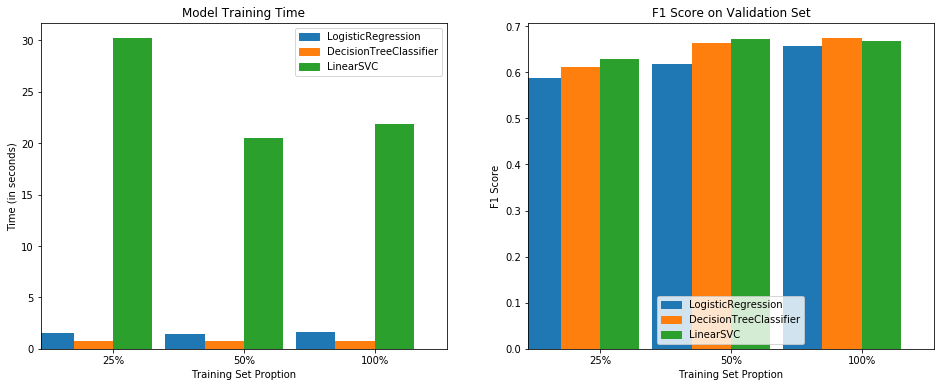

In [212]:
# 对比模型
plt.figure(1, figsize=(16,6))

bar_width = 0.3
colors = ['#1F77B4','#FF7F0E','#2CA02C']
  
plt.subplot(1,2,1)
# Super loop to plot four panels of data
for k, clf in enumerate(results.keys()):
    for i in np.arange(3):
        plt.bar(i+k*bar_width, results[clf][i]['train_time'], width = bar_width, color = colors[k])
        plt.xticks([0.45, 1.45, 2.45],["25%", "50%", "100%"])
        plt.xlabel("Training Set Proption")
        plt.xlim((-0.1, 3.0))
        
patches = []
for k, clf in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[k], label = clf))
plt.legend(handles = patches,loc='upper right')
plt.ylabel("Time (in seconds)")
plt.title("Model Training Time")

plt.subplot(1,2,2)
# Super loop to plot four panels of data
for k, clf in enumerate(results.keys()):
    for i in np.arange(3):
        plt.bar(i+k*bar_width, results[clf][i]['f1'], width = bar_width, color = colors[k])
        plt.xticks([0.45, 1.45, 2.45],["25%", "50%", "100%"])
        plt.xlabel("Training Set Proption")
        plt.xlim((-0.1, 3.0))

plt.legend(handles = patches, loc='lower center')
plt.ylabel("F1 Score")
plt.title("F1 Score on Validation Set");

+ 从训练时间上来看，随着数据量的增加，逻辑回归和决策树在训练时间上并无明显变化，SVM的训练时间有所降低，但仍是前两者的十几倍
+ 从f1 score上来看，随着数据量的增加，三种算均有提高f1 score, 其中决策树提升最快，且高于其他模型。 

**综合训练时间和f1 score来看，决策树可以应用到更大规模的数据中，鲁棒性强，所以选择决策树模型**

### 模型调优
利用网格搜索和交叉验证，找到决策树的最优参数

In [165]:
# 决策树模型调优
dt = DecisionTreeClassifier(featuresCol="features", \
                            labelCol="label", \
                            seed=42)
paramGrid = ParamGridBuilder() \
            .addGrid(dt.maxDepth, [3,5,8,10,15,20]) \
            .addGrid(dt.maxBins, [16,32,64,128]) \
            .addGrid(dt.minInfoGain, [0.01, 0.02, 0.03,0.05,0.1]) \
            .addGrid(dt.minInstancesPerNode, [5,10,15,20]) \
            .build()

cv = CrossValidator(estimator = dt, \
                   estimatorParamMaps=paramGrid, \
                   evaluator=evaluator_f1, \
                   numFolds=5)

cv_model = cv.fit(train_data)

In [211]:
# 查看最优参数
cv_model.bestModel.extractParamMap()

{Param(parent='DecisionTreeClassifier_94b808ba5307', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_94b808ba5307', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_94b808ba5307', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_94b808ba5307', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_94b808ba5307', name='labelCol', doc='label column name'): 'lab

由以上可知，最优参数为
+ impurity: gini
+ maxBins: 16
+ maxDepth: 3
+ minInfoGain: 0.03
+ minInstancesPerNode: 5

In [166]:
# 查看调优后的模型在测试集上的f1 score
test_predict = cv_model.transform(test_data)
f1 = evaluator_f1.evaluate(test_predict)
print('test data F1 score: {:.4f}'.format(f1))

test data F1 score: 0.5865


## 结论
　　本文根据sparkify的子集，研究了流失用户的特征，并根据此特征建立了决策树模型。调优后的模型在测试集的f1 score为0.5865。  
　　首先进行了数据清理，丢弃缺失数据行，并转换了日期格式；然后数据可视化探索，对比会员用户和流失用户的行为差异。一个值得注意的地方是，流失用户更加活跃，无论是从注册以来活跃天数的比例，还是最近两周听歌的数量、最近两周活跃的天数，都比现有会员用户高。可能的原因是活跃度高的用户对sparkify的用户体验要求更高。因为经常使用，一些设计瑕疵会严重影响用户体验，导致用户流失。这点需要在更大的数据集上验证。  
　　调优后的决策树模型虽然有了提升，但实际上比天真预测器还要差些。原因是数据集太小了，只是完整数据集的1.8%，测试集数据量就更小，只有26个用户。预测数量上增加一个或者减少一个，会极大的影响评估指标。所以下一步改进的方向是在更大的数据集训练和调优模型。